<a href="https://colab.research.google.com/github/tomiambro/ap_automatico/blob/tps-tomi/tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA

#Otros 
import warnings
warnings.filterwarnings('ignore')

## Descargar y descomprimir el dataset

El archivo se va a descargar en el path 'root_path'

In [3]:
root_path = 'gdrive/MyDrive/machine_learning/ap_automatico'  # Modificar con el nombre de la carpeta donde vayas a bajar los datos

In [4]:
# download dataset
import requests
from os.path import exists

if not exists(f"{root_path}/dataset.zip"): 
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
  r = requests.get(url, allow_redirects=True)

  open(f"{root_path}/dataset.zip", 'wb').write(r.content)

In [5]:
# unzip dataset

if not exists(f"{root_path}/dataset.zip"): 
  import zipfile
  with zipfile.ZipFile(f"{root_path}/dataset.zip", 'r') as zip_ref:
      zip_ref.extractall(root_path)

## Cargamos el dataset en un DataFrame

In [6]:
from sklearn.preprocessing import label_binarize

In [7]:
df_raw = pd.read_csv(f"{root_path}/bank-full.csv", delimiter=';')
df_raw.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [8]:
df_raw.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Revisamos que no falten datos

In [9]:
df_raw.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Descartamos la columna 'duration' segun lo especificado por las notas del dataset:

'*duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*'

In [10]:
df = df_raw.drop('duration', axis=1)
df.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,2,188,11,other,no


### Pasamos las columnas que tienen datos categoricos a variables numericas

In [11]:
# Primero pasamos nuestra 'y'
df.loc[:, 'y'] = label_binarize(df['y'], classes=['no', 'yes'])
df.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,0
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,2,188,11,other,0


In [12]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
  print(col)
  print(pd.Categorical(df[col]).categories)
  df.loc[:, col] = pd.Categorical(df[col]).codes

df.tail(5) 

job
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')
marital
Index(['divorced', 'married', 'single'], dtype='object')
education
Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')
default
Index(['no', 'yes'], dtype='object')
housing
Index(['no', 'yes'], dtype='object')
loan
Index(['no', 'yes'], dtype='object')
contact
Index(['cellular', 'telephone', 'unknown'], dtype='object')
month
Index(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov',
       'oct', 'sep'],
      dtype='object')
poutcome
Index(['failure', 'other', 'success', 'unknown'], dtype='object')


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
45206,51,9,1,2,0,825,0,0,0,17,9,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,4,-1,0,3,0
45210,37,2,1,1,0,2971,0,0,0,17,9,2,188,11,1,0


In [13]:
df.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,4.339762,1.167725,1.224813,0.018027,1362.272058,0.555838,0.160226,0.640242,15.806419,5.523014,2.763841,40.197828,0.580323,2.559974,0.116985
std,10.618762,3.272657,0.608230,0.747997,0.133049,3044.765829,0.496878,0.366820,0.897951,8.322476,3.006911,3.098021,100.128746,2.303441,0.989059,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,2.000000,21.000000,8.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,63.000000,871.000000,275.000000,3.000000,1.000000


## EDA

### Heatmap

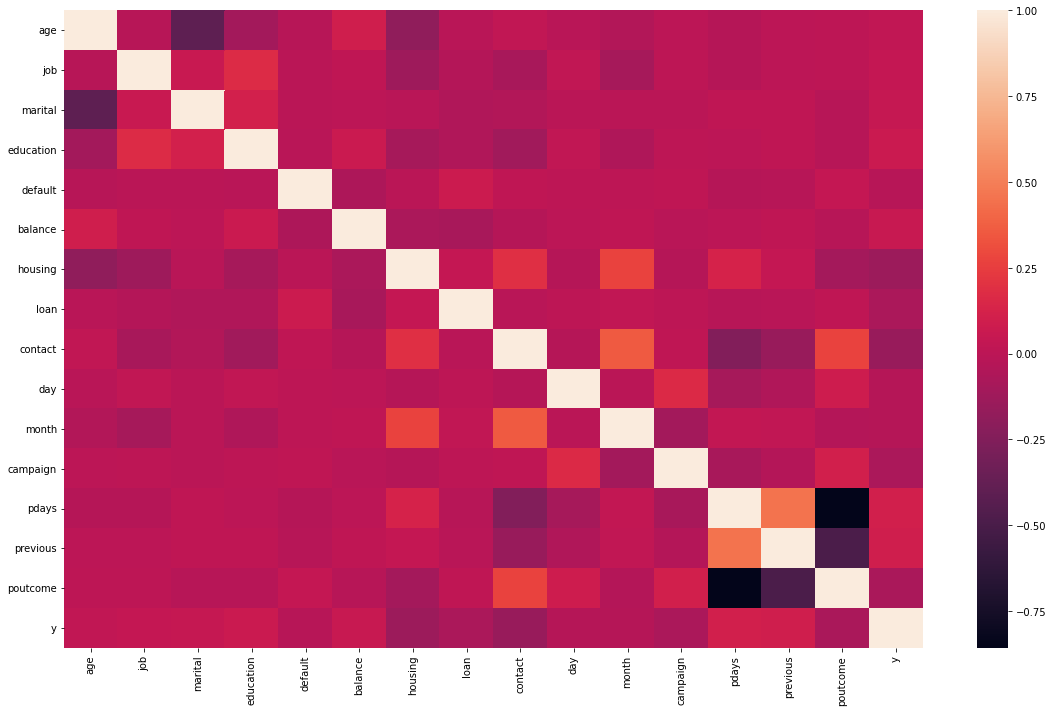

In [14]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr())
plt.tight_layout()

### Boxplot

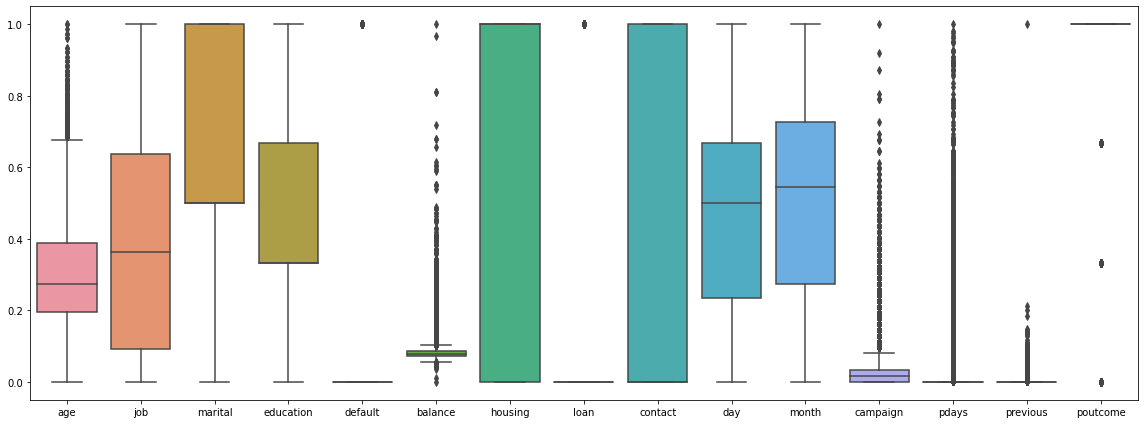

In [15]:
scal = MinMaxScaler()
df_normal = scal.fit_transform(df.drop('y', axis=1))
cols = df.columns
cols = cols.drop('y')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

<Figure size 1152x1224 with 0 Axes>

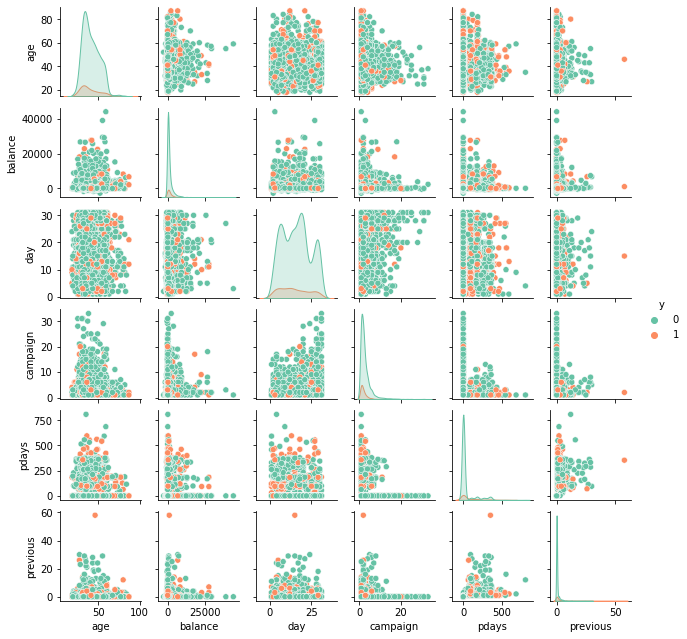

In [16]:
plt.figure(figsize=(16,17))
g = sns.pairplot(data=df.drop(cat_cols, axis=1).sample(frac=0.1, random_state=42), hue='y', palette='Set2', height=1.5)

g.tight_layout()
plt.show()

In [17]:
scal = StandardScaler()
df_scal = scal.fit_transform(df.drop('y', axis=1))

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scal)
xpca = pd.DataFrame(df_pca)

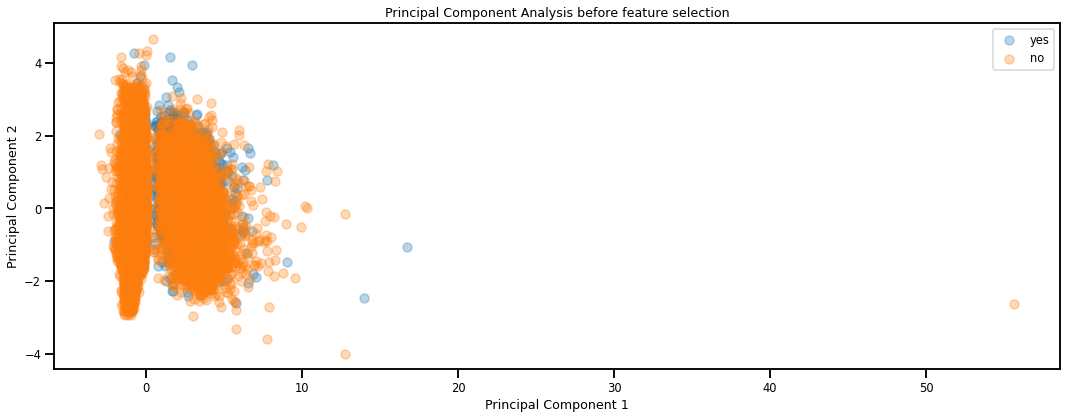

In [18]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))

plt.scatter(xpca.loc[(df_raw['y'] == 'yes').ravel(),0],xpca.loc[(df_raw['y'] == 'yes').ravel(),1], alpha = 0.3, label = 'yes')
plt.scatter(xpca.loc[(df_raw['y'] == 'no').ravel(),0],xpca.loc[(df_raw['y'] == 'no').ravel(),1], alpha = 0.3, label = 'no')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

A simple vista no parecen ser linealmente separables

## Entrenamos algunos modelos

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve

### Revisamos el balance entre clases

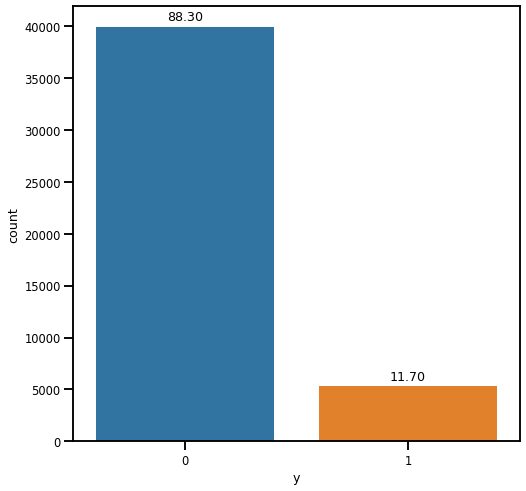

In [20]:
plt.figure(figsize=(8,8))
splot = sns.countplot(x='y', data=df)

for p in splot.patches:
    splot.annotate(format(p.get_height()/df.shape[0]*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Dado que hay un claro desbalance elegimos las metricas de area bajo la curva ROC y el valor F1 para una correcta interpretacion de la utilidad del modelo.

### Particionamos el dataset en train y test

In [21]:
X = df.drop('y', axis=1)
y = df['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

### Modelo de base

Definimos los modelos que vamos a entrenar

In [22]:
ypreds = {}
m = {}

res = pd.DataFrame({'model':[], 'roc validation':[], 'roc test':[], 'f1 test':[]})

models = {
        'Logistic Regression': LogisticRegression(n_jobs = -1, random_state=1, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(300, n_jobs = -1, random_state=1, class_weight='balanced'),
        'SVC': SVC(random_state=1, class_weight='balanced'),
        'KNNeighbors': KNeighborsClassifier(n_jobs = -1),
        'LDA': LinearDiscriminantAnalysis()
}

In [23]:
scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [24]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
scores = cross_val_score(dc, xtrain_scal, ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
dc.fit(xtrain_scal, ytrain)
ypred = dc.predict(xtest_scal)
res = res.append({'model': 'Baseline', 'roc validation': scores.mean(), 'roc test': roc_auc_score(ytest, ypred), 'f1 test': f1_score(ytest, ypred)}, ignore_index=True)
res

,model,roc validation,roc test,f1 test
0,Baseline,0.500278,0.501296,0.117308


In [25]:
def train_models(X, y, xtest, title=''):
  res = []
  
  for name, model in models.items():
    print(name)
    # Model training with cross validation
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    model.fit(X, y)
    
    ypred = model.predict(xtest)
    roc = roc_auc_score(ytest, ypred)
    ypreds[f'{name} {title}'] = ypred
    m[f'{name} {title}'] = model
    
    # Save the results to a dataframe
    # res = res.append(, ignore_index=True)
    res.append({'model': f'{name} {title}', 'roc validation': scores.mean(), 'roc test': roc, 'f1 test': f1_score(ytest, ypred)})
  return res

In [26]:
results = train_models(xtrain_scal, ytrain, xtest_scal, 'MinMax')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [27]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
3,SVC MinMax,0.740605,0.695013,0.357516
1,Logistic Regression MinMax,0.718197,0.664755,0.308879
2,Random Forest MinMax,0.779734,0.588948,0.294585
4,KNNeighbors MinMax,0.672650,0.588215,0.289636
0,Baseline,0.500278,0.501296,0.117308
5,LDA MinMax,0.713488,0.511457,0.050542


### Descartamos todo por encima del percentil 99.99

In [28]:
aux = df.copy()
cols = df.columns
cols = cols.drop('y')
for col in cols:
    aux = aux[aux[col] < aux[col].quantile(.9999)]
    print(col, aux.shape[0])

df_9999 = aux.copy()
df_9999.shape[0]

age 45206
job 44918
marital 32196
education 30971
default 30418
balance 30414
housing 13107
loan 11157
contact 8980
day 8784
month 8539
campaign 8538
pdays 8537
previous 8536
poutcome 1572


1572

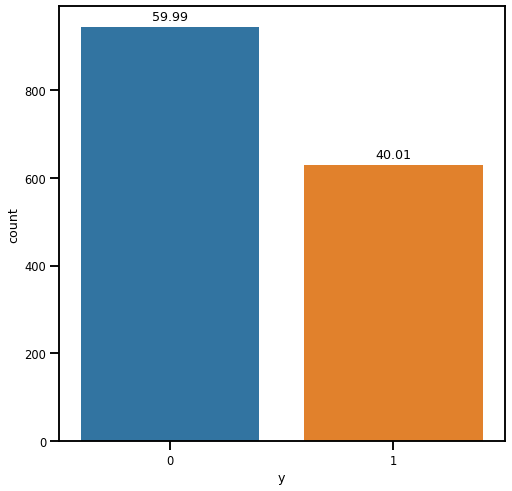

In [29]:
plt.figure(figsize=(8,8))
splot = sns.countplot(x='y', data=df_9999)

for p in splot.patches:
    splot.annotate(format(p.get_height()/df_9999.shape[0]*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [30]:
X = df_9999.drop('y', axis=1)
y = df_9999['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [31]:
results = train_models(xtrain_scal, ytrain, xtest_scal, title='MinMax Perc 99.99')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [32]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
8,SVC MinMax Perc 99.99,0.732848,0.752646,0.697479
7,Random Forest MinMax Perc 99.99,0.762261,0.748677,0.691983
10,LDA MinMax Perc 99.99,0.737129,0.746032,0.691358
6,Logistic Regression MinMax Perc 99.99,0.735365,0.722222,0.674157
9,KNNeighbors MinMax Perc 99.99,0.683570,0.705026,0.632035
3,SVC MinMax,0.740605,0.695013,0.357516
1,Logistic Regression MinMax,0.718197,0.664755,0.308879
2,Random Forest MinMax,0.779734,0.588948,0.294585
4,KNNeighbors MinMax,0.672650,0.588215,0.289636
0,Baseline,0.500278,0.501296,0.117308


In [33]:
aux = df.copy()
cols = df.columns
cols = cols.drop('y')
for col in cols:
    aux = aux[aux[col] < aux[col].quantile(.999)]
    
df_999 = aux.copy()

df_999.shape[0]

1544

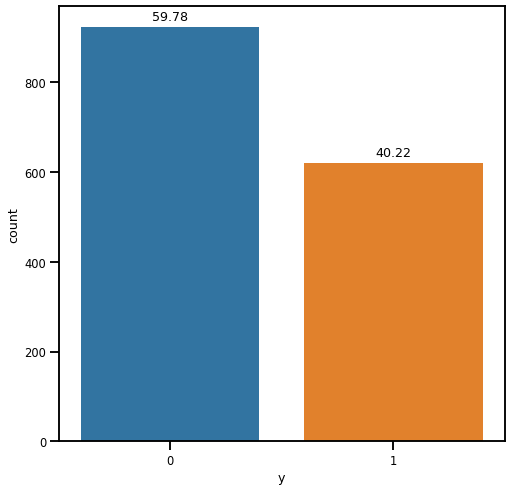

In [34]:
plt.figure(figsize=(8,8))
splot = sns.countplot(x='y', data=df_999)

for p in splot.patches:
    splot.annotate(format(p.get_height()/df_999.shape[0]*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [35]:
X = df_999.drop('y', axis=1)
y = df_999['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [36]:
results = train_models(xtrain_scal, ytrain, xtest_scal, title='MinMax Perc 99.9')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [37]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
8,SVC MinMax Perc 99.99,0.732848,0.752646,0.697479
7,Random Forest MinMax Perc 99.99,0.762261,0.748677,0.691983
10,LDA MinMax Perc 99.99,0.737129,0.746032,0.691358
6,Logistic Regression MinMax Perc 99.99,0.735365,0.722222,0.674157
9,KNNeighbors MinMax Perc 99.99,0.683570,0.705026,0.632035
13,SVC MinMax Perc 99.9,0.761374,0.690280,0.605505
15,LDA MinMax Perc 99.9,0.757986,0.682587,0.601770
11,Logistic Regression MinMax Perc 99.9,0.757633,0.659509,0.592000
12,Random Forest MinMax Perc 99.9,0.777456,0.671092,0.576744
14,KNNeighbors MinMax Perc 99.9,0.717626,0.644496,0.551111


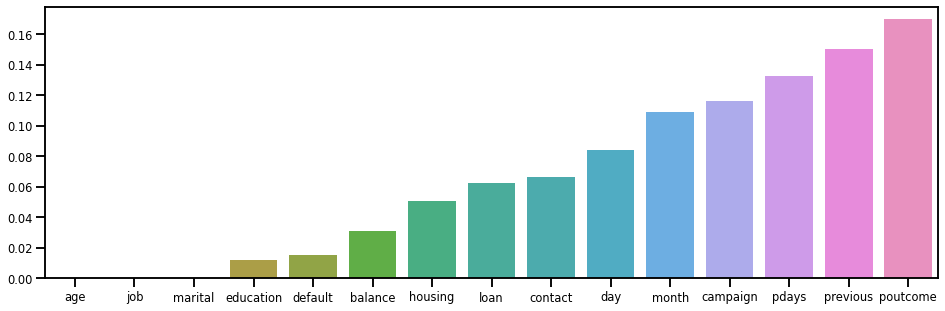

In [38]:
plt.figure(figsize=(16,5))
sns.barplot(df_9999.columns.drop('y'), np.sort(m['Random Forest MinMax Perc 99.99'].feature_importances_))
plt.show()

In [39]:
df_drop = df_9999.drop(['age', 'job', 'marital'], axis=1)

X = df_drop.drop('y', axis=1)
y = df_drop['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

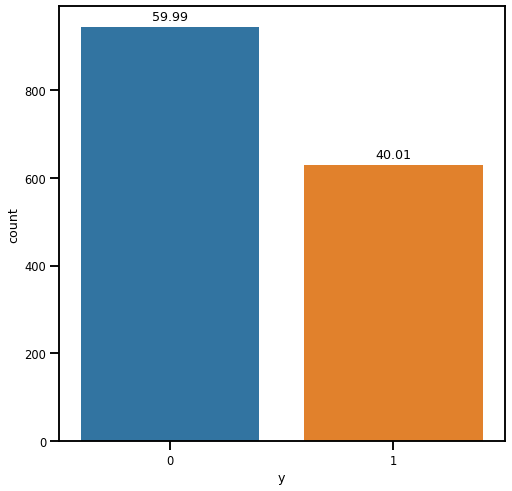

In [40]:
plt.figure(figsize=(8,8))
splot = sns.countplot(x='y', data=df_drop)

for p in splot.patches:
    splot.annotate(format(p.get_height()/df_drop.shape[0]*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [41]:
results = train_models(xtrain_scal, ytrain, xtest_scal, title='MinMax Perc 99.99 Drop')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [42]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
20,LDA MinMax Perc 99.99 Drop,0.728968,0.757937,0.705394
18,SVC MinMax Perc 99.99 Drop,0.727868,0.757937,0.703390
8,SVC MinMax Perc 99.99,0.732848,0.752646,0.697479
7,Random Forest MinMax Perc 99.99,0.762261,0.748677,0.691983
10,LDA MinMax Perc 99.99,0.737129,0.746032,0.691358
17,Random Forest MinMax Perc 99.99 Drop,0.770000,0.744709,0.686441
6,Logistic Regression MinMax Perc 99.99,0.735365,0.722222,0.674157
16,Logistic Regression MinMax Perc 99.99 Drop,0.727893,0.714286,0.666667
19,KNNeighbors MinMax Perc 99.99 Drop,0.697336,0.716931,0.649573
9,KNNeighbors MinMax Perc 99.99,0.683570,0.705026,0.632035


### Probamos usando dummies

In [44]:
df_dummy = df_raw.drop(['age', 'job', 'marital', 'duration'], axis=1)

df_dummy['y'] = label_binarize(df_dummy['y'], classes=['no', 'yes'])
df_dummy = pd.get_dummies(df_dummy)

df_dummy.tail()

,balance,day,campaign,pdays,previous,y,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
45206,825,17,3,-1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
45207,1729,17,2,-1,0,1,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
45208,5715,17,5,184,3,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
45209,668,17,4,-1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
45210,2971,17,2,188,11,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [45]:
X = df_dummy.drop('y', axis=1)
y = df_dummy['y']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [46]:
results = train_models(xtrain_scal, ytrain, xtest_scal, title='MinMax Dummies Drop')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [47]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
20,LDA MinMax Perc 99.99 Drop,0.728968,0.757937,0.705394
18,SVC MinMax Perc 99.99 Drop,0.727868,0.757937,0.703390
8,SVC MinMax Perc 99.99,0.732848,0.752646,0.697479
7,Random Forest MinMax Perc 99.99,0.762261,0.748677,0.691983
10,LDA MinMax Perc 99.99,0.737129,0.746032,0.691358
17,Random Forest MinMax Perc 99.99 Drop,0.770000,0.744709,0.686441
6,Logistic Regression MinMax Perc 99.99,0.735365,0.722222,0.674157
16,Logistic Regression MinMax Perc 99.99 Drop,0.727893,0.714286,0.666667
19,KNNeighbors MinMax Perc 99.99 Drop,0.697336,0.716931,0.649573
9,KNNeighbors MinMax Perc 99.99,0.683570,0.705026,0.632035


### Matriz de confusion del mejor modelo

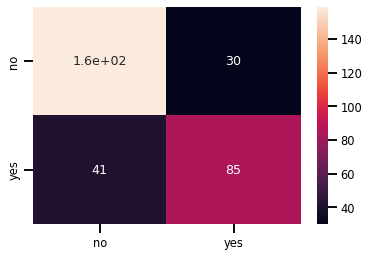

In [43]:
cm = confusion_matrix(ytest, ypreds['LDA MinMax Perc 99.99 Drop'])
df_cm = pd.DataFrame(cm, index = ['no', 'yes'], columns = ['no', 'yes'])

sns.heatmap(df_cm, annot=True)
plt.show()